# Data Preparation

## Convert to YOLO Format

In [ ]:
import PIL.Image
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
from ultralytics.data.converter import convert_coco

### FloorPlanCAD dataset

In [ ]:
convert_coco(
    labels_dir="data/cad/annotations",
    save_dir="data/cad_yolo",
    use_segments=True,
    cls91to80=False
)

### SFPI dataset

In [ ]:
convert_coco(
    labels_dir="data/sfpi/annotations",
    save_dir="data/sfpi_yolo",
    use_segments=True,
    cls91to80=False
)

## Join Datasets

# Ultralytics YOLO

## Load Model

In [4]:
from ultralytics import YOLO

model = YOLO("object_detection/models/yolo11l.pt")

## Train Model

In [5]:
model.train(
    data="object_detection/cad.yaml",
    epochs=20,
    batch=16,
    imgsz=640,
    device=0,
    optimizer="AdamW",
    lr0=1e-3,
    freeze=0,
    name="cad-seg-run"
)

model.save("object_detection/models/yolo11l-tuned.pt")

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.127 🚀 Python-3.12.3 torch-2.7.0+cu128 CUDA:0 (NVIDIA GeForce RTX 5070 Ti, 16303MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=object_detection/cad.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=object_detection/models/yolo11l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=cad-seg-run6,

train: Scanning /home/ubuntu/floor-plan-net/data/cad/labels/train-01.cache... 4336 images, 2065 backgrounds, 0 corrupt: 100%|██████████| 6401/6401 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 315.2±158.5 MB/s, size: 145.5 KB)


val: Scanning /home/ubuntu/floor-plan-net/data/cad/labels/train-00.cache... 2903 images, 857 backgrounds, 0 corrupt: 100%|██████████| 3760/3760 [00:00<?, ?it/s]


Plotting labels to runs/detect/cad-seg-run6/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/cad-seg-run6
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      10.2G     0.9615      1.666      1.031         28        640: 100%|██████████| 401/401 [01:42<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  76%|███████▋  | 90/118 [00:20<00:06,  4.36it/s]


KeyboardInterrupt: 

## Evaluate Model

In [1]:
from ultralytics import YOLO

model = YOLO("object_detection/models/yolo11l-seg-cad.pt")

In [ ]:
model.val()

## Make Predictions

In [15]:
from PIL import Image
raw = Image.open("data/cad/images/train-01/0001-0040.png").convert("RGBA")
bg  = Image.new("RGBA", raw.size, (255, 255, 255, 255))
image = Image.alpha_composite(bg, raw).convert("RGB")

model.predict(image, save=True)

prediction = Image.open("runs/segment/predict/image0.jpg").convert("RGBA")


0: 640x640 6 single doors, 8 windows, 7 opening symbols, 2 sofas, 1 bed, 2 chairs, 2 tables, 1 tv cabinet, 2 wardrobes, 3 cabinets, 1 refrigerator, 5 airconditioners, 1 gas stove, 2 sinks, 1 washing machine, 1 toilet, 127.5ms
Speed: 3.4ms preprocess, 127.5ms inference, 35.7ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/segment/predict


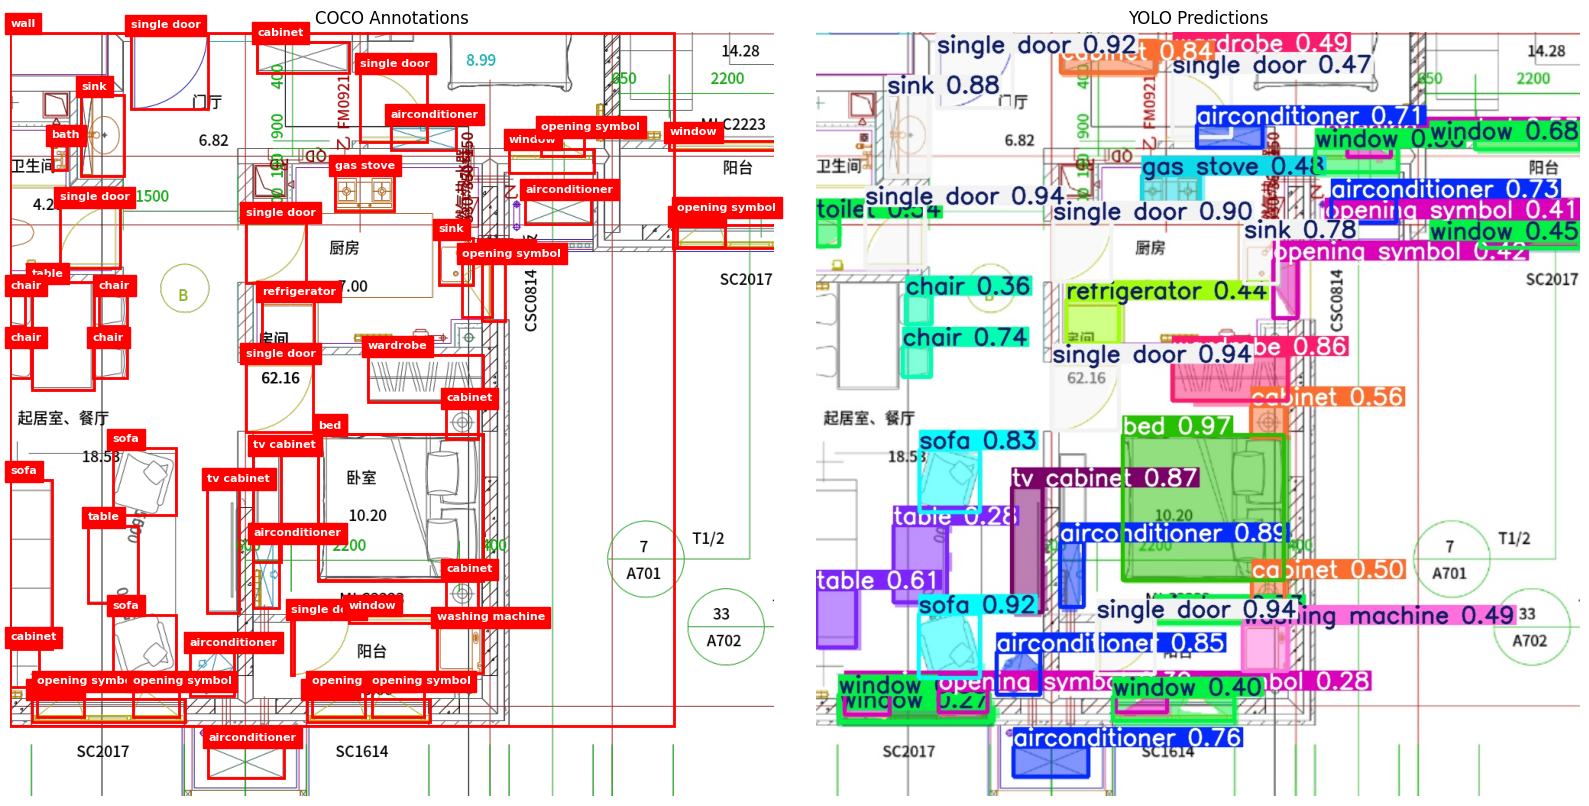

In [17]:
import matplotlib.pyplot as plt
from object_detection.coco_visualizer import visualize_coco_annotations

# 1) Load your base image

# 2) Create a 1×2 subplot
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# 4) Draw COCO annotations on the right subplot
visualize_coco_annotations(
    "data/cad/annotations/train-01-annotations.json",
    "0001-0040.png",
    "data/cad/images/train-01",
    ax=axes[0],
    show=False
)
axes[0].set_title("COCO Annotations")

axes[1].imshow(prediction)
axes[1].set_title("YOLO Predictions")
axes[1].axis("off")

# 5) Finish up
plt.tight_layout()
plt.show()

# MobileNet V3 Faster R-CNN

## YOLO-Style Dataset

In [1]:
import os
import glob
from PIL import Image
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torch.multiprocessing as mp

mp.set_sharing_strategy('file_system')

class YOLODataset(Dataset):
    def __init__(self, images_root, labels_root, splits=None, transforms=None, scale: float = 1.0):
        self.images_root = images_root
        self.labels_root = labels_root
        self.transforms  = transforms
        self.scale       = scale

        # collect all files under the requested splits
        img_paths = []
        if splits:
            for split in splits:
                img_paths += glob.glob(os.path.join(images_root, split, "*.*"))
        else:
            img_paths = glob.glob(os.path.join(images_root, "**", "*.*"), recursive=True)

        # keep only raster images
        self.images = sorted(p for p in img_paths if p.lower().endswith(('.jpg','.jpeg','.png')))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        rel      = os.path.relpath(img_path, self.images_root)
        lbl_path = os.path.join(self.labels_root, os.path.splitext(rel)[0] + ".txt")

        # 1) load PIL image
        img = Image.open(img_path).convert("RGB")
        orig_w, orig_h = img.size

        # 2) resize image
        new_w, new_h = int(orig_w * self.scale), int(orig_h * self.scale)
        img = img.resize((new_w, new_h), Image.BILINEAR)

        # 3) parse normalized YOLO labels *onto the new size*
        boxes, labels = [], []
        if os.path.exists(lbl_path):
            with open(lbl_path) as f:
                for line in f:
                    cls, xc, yc, bw, bh = map(float, line.split()[:5])
                    xmin = (xc - bw/2) * new_w
                    ymin = (yc - bh/2) * new_h
                    xmax = (xc + bw/2) * new_w
                    ymax = (yc + bh/2) * new_h
                    if xmax > xmin and ymax > ymin:
                        boxes.append([xmin, ymin, xmax, ymax])
                        labels.append(int(cls + 1))

        # 4) to tensors (even if empty)
        if boxes:
            boxes  = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.tensor(labels, dtype=torch.int64)
        else:
            boxes  = torch.zeros((0,4), dtype=torch.float32)
            labels = torch.zeros((0,),   dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([idx])}

        # 5) tensor‐ify image
        img = torchvision.transforms.ToTensor()(img)

        # 6) any extra transforms
        if self.transforms:
            img, target = self.transforms(img, target)

        return img, target

def collate_fn(batch):
    return tuple(zip(*batch))

batch_size   = 64
train_splits = ["train-00","train-01"]
val_splits   = ["test-00"]

train_ds = YOLODataset("data/cad/images", "data/cad/labels", splits=train_splits, scale=0.5)
val_ds   = YOLODataset("data/cad/images", "data/cad/labels", splits=val_splits, scale=0.5)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=4)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=2)


## Hyperparameters

In [2]:
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights, FasterRCNN_MobileNet_V3_Large_320_FPN_Weights

num_epochs   = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_320_fpn(weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT)
in_feats = model.roi_heads.box_predictor.cls_score.in_features
NUM_CLASSES = 32
model.roi_heads.box_predictor = FastRCNNPredictor(in_feats, NUM_CLASSES)
model.to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,         # start lower than SGD; you can experiment 1e-5–1e-3
    weight_decay=1e-4
)

map_metric = MeanAveragePrecision(box_format='xyxy', iou_type='bbox')

/home/ubuntu/.virtualenvs/pytorch/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_MobileNet_V3_Large_320_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Train Model

In [3]:
from tqdm.notebook import tqdm
import gc

for epoch in tqdm(range(num_epochs), desc="Epochs"):
    # — Training —
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    model.train()
    train_bar = tqdm(train_loader, desc=f"Train [{epoch}]", leave=True, position=0)
    for images, targets in train_bar:
        images  = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k,v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # GPU memory (in GB)
        if device.type == 'cuda':
            mem_alloc    = torch.cuda.memory_allocated() / 1e9
            mem_reserved = torch.cuda.memory_reserved()  / 1e9
            train_bar.set_postfix({
                "loss": f"{loss.item():.3f}",
                "mem_alloc": f"{mem_alloc:.2f}G",
                "mem_resrv": f"{mem_reserved:.2f}G"
            })
        else:
            train_bar.set_postfix({"loss": f"{loss.item():.3f}"})
    train_bar.close()      # explicitly close


    # — Validation / Metrics —
    model.roi_heads.score_thresh = 0.25
    model.eval()
    map_metric.reset()
    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc=f"Val [{epoch}]", leave=True, position=1):
            imgs_cpu    = [img.to(device) for img in images]
            preds       = model(imgs_cpu)
            # move everything to CPU for metric
            preds_cpu   = [{k: v.cpu() for k,v in p.items()} for p in preds]
            targets_cpu = [{k: v.cpu() for k,v in t.items()} for t in targets]

            # 4) update metric with the filtered predictions
            map_metric.update(preds_cpu, targets_cpu)
    metrics = map_metric.compute()
    P        = metrics['precision'].mean().item()    if 'precision' in metrics else float('nan')
    R        = metrics['recall'].mean().item()       if 'recall'    in metrics else float('nan')
    mAP50    = metrics.get('map_50', 0.0).item()
    mAP50_95 = metrics.get('map',    0.0).item()

    tqdm.write(
        f"Box(P {P:.3f} R {R:.3f} mAP50 {mAP50:.3f} mAP50-95 {mAP50_95:.3f})"
    )

print("Training complete.")

Epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Train [0]:   0%|          | 0/159 [00:00<?, ?it/s]

Val [0]:   0%|          | 0/86 [00:00<?, ?it/s]

Box(P nan R nan mAP50 0.015 mAP50-95 0.006)


Train [1]:   0%|          | 0/159 [00:00<?, ?it/s]

Val [1]:   0%|          | 0/86 [00:00<?, ?it/s]

Box(P nan R nan mAP50 0.083 mAP50-95 0.036)


Train [2]:   0%|          | 0/159 [00:00<?, ?it/s]

Val [2]:   0%|          | 0/86 [00:00<?, ?it/s]

Box(P nan R nan mAP50 0.154 mAP50-95 0.066)


Train [3]:   0%|          | 0/159 [00:00<?, ?it/s]

Val [3]:   0%|          | 0/86 [00:00<?, ?it/s]

Box(P nan R nan mAP50 0.177 mAP50-95 0.083)


Train [4]:   0%|          | 0/159 [00:00<?, ?it/s]

Val [4]:   0%|          | 0/86 [00:00<?, ?it/s]

Box(P nan R nan mAP50 0.201 mAP50-95 0.097)


Train [5]:   0%|          | 0/159 [00:00<?, ?it/s]

Val [5]:   0%|          | 0/86 [00:00<?, ?it/s]

Box(P nan R nan mAP50 0.234 mAP50-95 0.112)


Train [6]:   0%|          | 0/159 [00:00<?, ?it/s]

Val [6]:   0%|          | 0/86 [00:00<?, ?it/s]

Box(P nan R nan mAP50 0.247 mAP50-95 0.121)


Train [7]:   0%|          | 0/159 [00:00<?, ?it/s]

Val [7]:   0%|          | 0/86 [00:00<?, ?it/s]

Box(P nan R nan mAP50 0.258 mAP50-95 0.129)


Train [8]:   0%|          | 0/159 [00:00<?, ?it/s]

Val [8]:   0%|          | 0/86 [00:00<?, ?it/s]

Box(P nan R nan mAP50 0.271 mAP50-95 0.136)


Train [9]:   0%|          | 0/159 [00:00<?, ?it/s]

Val [9]:   0%|          | 0/86 [00:00<?, ?it/s]

Box(P nan R nan mAP50 0.265 mAP50-95 0.135)
Training complete.
